In [1]:
import pickle
import datetime

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import numpy as np
import seaborn
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tensorboard import SummaryWriter

# Data loading
- Load csv into three separate pytorch "DataLoader"s, train, validation, and test.

In [122]:
dataset_ = pd.read_csv('./oracle_data.csv')

# Pick out data only where object pose changed
changed_inds = (dataset_['y_0'] != dataset_['y\'_0']) | (dataset_['y_1'] != dataset_['y\'_1']) | (dataset_['y_2'] != dataset_['y\'_2'])
dataset_ = dataset_[changed_inds]
dataset = dataset_.copy()

# Ignore robot successor state
dataset = dataset[[c for c in dataset.columns if 'x\'' not in c]]

# robot relative position
object_pos = dataset[[c for c in dataset.columns if 'y_' in c]]
for i in range(2):
    dataset.loc[:, 'x_{}'.format(i)] -= dataset['y_{}'.format(i)].values
# relative object change
for i in range(3):
    dataset.loc[:, 'y\'_{}'.format(i)] -= dataset['y_{}'.format(i)].values
# drop initial object x, y
dataset = dataset[[c for c in dataset.columns if c not in ['y_0', 'y_1']]]

# Remake angles θ to cos(θ), sin(θ). Redo as more automatically?
angles = dataset['x_2'].copy()
dataset['x_2'] = angles.apply('cos')
dataset['x_3'] = angles.apply('sin')
angles = dataset['y_2'].copy()
dataset['y_2'] = angles.apply('cos')
dataset['y_3'] = angles.apply('sin')
angles = dataset['y\'_2'].copy()
dataset['y\'_2'] = angles.apply('cos')
dataset['y\'_3'] = angles.apply('sin')

dataset = dataset[['x_0', 'x_1', 'x_2', 'x_3', 'y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2', 'y\'_3',
                   'u_0', 'u_1', 'u_2', 'u_3', 'u_4']]

# Decide where to split in training/validation/test
train_cut = int(len(dataset) * 0.9)
valid_cut = train_cut + int(len(dataset) * 0.05)
dataset_train_ = dataset[:train_cut]
dataset_val_ = dataset[train_cut:valid_cut]
dataset_test_ = dataset[valid_cut:]

# Normalize by training set statistics
training_µ = dataset_train_.mean()
training_σ = dataset_train_.std()
dataset_train = (dataset_train_ - training_µ) / training_σ
dataset_val = (dataset_train_ - training_µ) / training_σ
dataset_test = (dataset_train_ - training_µ) / training_σ

def get_dataloader(dataset, batch_size=32):
    X = dataset[[name for name in dataset.columns if not name.startswith('u')]]
    Y = dataset[[name for name in dataset.columns if name.startswith('u')]]
    return DataLoader(
        list(zip(X.as_matrix().astype(np.float32), Y.as_matrix().astype(np.float32))),
        batch_size=batch_size,
        shuffle=True
    )

dataloader_train = get_dataloader(dataset_train)
dataloader_val = get_dataloader(dataset_val, batch_size=128)
dataloader_test = get_dataloader(dataset_test, batch_size=128)

In [123]:
dataset_

,x_0,x_1,x_2,y_0,y_1,y_2,x'_0,x'_1,x'_2,y'_0,y'_1,y'_2,u_0,u_1,u_2,u_3,u_4
28,-0.394126,0.994688,-2.819700,0.135810,-0.311288,-2.936730,0.863803,-1.163890,-1.512680,-0.902363,-3.149270,-211.501000,1.112050,-1.944450,1.161550,0.159846,8.00009
81,1.715370,0.338092,2.061680,0.330714,0.216791,-2.829220,-0.330708,0.291698,1.534850,-4.228600,2.208120,-57.792200,-1.828690,-0.040563,-0.485500,0.228786,8.00009
96,0.358663,1.132020,-0.775950,0.618190,-0.616505,1.139030,0.569226,-1.934760,0.222031,1.868990,-1.733000,246.450000,0.128419,-1.897350,0.606969,0.692946,8.00009
109,1.696870,0.518726,-2.417190,0.871611,0.800647,-2.947050,0.172123,1.041010,-0.887129,-0.746407,1.667410,-79.018400,-0.983225,0.336806,0.984748,0.849604,8.00009
139,-0.276851,-1.883570,-2.336900,-0.853011,1.993890,1.665900,1.121380,-1.621500,-2.728040,-0.853012,1.993890,1.665900,1.112370,0.206261,-0.307619,0.715966,0.00000
141,-1.294730,-0.082392,2.981140,0.729555,0.573355,-0.444367,0.513942,0.662981,3.806890,0.929303,0.538268,-31.676500,1.659560,0.672096,0.744094,0.280313,8.00009
167,-1.075390,1.380310,-2.933310,-0.401199,1.709660,2.580980,-3.431010,2.839900,-3.389830,-0.401198,1.709660,2.580980,-1.591840,0.975319,-0.304972,0.701837,0.01000
185,-1.876790,1.078790,-1.890780,0.701342,-0.144400,0.931588,-2.919250,0.165891,-2.300510,0.701343,-0.144400,0.931588,-0.963231,-0.836771,-0.375298,0.610587,0.00000
199,1.302940,1.364180,-1.370900,1.969860,-0.555616,-2.730690,1.908890,-1.593140,-0.444253,4.633950,-2.345490,206.489000,0.398008,-1.973710,0.593960,0.537147,8.00009
202,-1.147020,0.672673,1.696920,-1.396370,0.055177,0.553092,-1.056500,1.841500,1.889500,-1.396370,0.055177,0.553092,0.075362,0.982891,0.160244,0.711545,0.00000


In [3]:
# redo same step to get input/output dimensions
X = dataset[[name for name in dataset.columns if not name.startswith('u')]]
Y = dataset[[name for name in dataset.columns if name.startswith('u')]]
x_size = len(X.columns)
y_size = len(Y.columns)
x_size, y_size

(10, 5)

# Define models
- Separate mean and variance models, for stability
- MSE loss for the mean, gaussian log likelihood for the variance
- Learn: $p(u|x_r, x_t, x_t')$

In [4]:
def n_fn(k):
    return int(k * (1 + k) / 2)


def k_fn(n):
    return int(-0.5 + (0.25 + 2 * n) ** 0.5)


hidden_size = 256
n_residual_units = 2
n_cholesky_entries = n_fn(y_size)


class CovarianceCholesky(torch.nn.Module):

    def __init__(self, n_features):
        super(CovarianceCholesky, self).__init__()
        self.k = n_features
        self.n = int(self.k * (1 + self.k) / 2)
        self.row_inds = []
        self.col_inds = []
        self.diagonal_inds = list(range(self.k))
        for i in range(1, self.k):
            for j in range(i):
                self.row_inds.append(i)
                self.col_inds.append(j)

    def forward(self, x):
        n = x.size(1)
        k = int(-0.5 + (0.25 + 2 * n) ** 0.5)
        y = Variable(torch.zeros(x.size(0), k, k))
        if x.data.is_cuda:
            y = y.cuda()
        y[:, self.row_inds, self.col_inds] = x[:, :n - k]
        y[:, self.diagonal_inds, self.diagonal_inds] = F.softplus(x[:, n - k:])
        return y

class Residual(torch.nn.Module):
    
    def __init__(self, num_features):
        super(Residual, self).__init__()
        self.bn1 = torch.nn.BatchNorm1d(num_features)
        self.fc1 = torch.nn.Linear(num_features, num_features)
        self.bn2 = torch.nn.BatchNorm1d(num_features)
        self.fc2 = torch.nn.Linear(num_features, num_features)
        
    def forward(self, x):
        a = self.fc1(F.relu(self.bn1(x)))
        b = self.fc2(F.relu(self.bn2(a)))
        return b + x
    

mean_model = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, y_size)
).cuda()

var_model = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, y_size),
    torch.nn.Softplus()
).cuda()

## Loss and optimizers

In [5]:
def gaussian_likelihood():
    def f(µ, σ, y):
        return (torch.log(σ) + 0.5 * (µ - y) * (µ - y) / (σ ** 2)).sum()
    return f

def multivariate_gaussian_likelihood(µ, L, y):
    """(Average) Negative log-likelihood of a multivariate gaussian.
    
    Notation below:
    n = Number of samples
    k = Dimensionality of gaussian variables

    µ : Variable, dimensions: (n, k)
    L : Lower triangular cholesky decomposition of the covariance matrices, that is LL' = Σ
        dimensions: (n, k, k)
    y : Variable, dimensions: (n, k)
    """
    n, k = µ.size()
    nll = Variable(torch.zeros(1))
    if µ.data.is_cuda:
        nll = nll.cuda()
    for i in range(n):
        l = L[i, :, :]
        L_inv = torch.inverse(l)
        Σ_inv = L_inv.transpose(0, 1) @ L_inv
        d = y[i:i + 1, :] - µ[i:i + 1, :]
        logdet = 2 * torch.log(l.diag()).sum()
        nll += 0.5 * (
            logdet +
            (d @ Σ_inv @ d.transpose(0, 1)).sum() +
            k * np.log(2 * np.pi)
        )
    return nll / n

mean_loss_fn = torch.nn.MSELoss()
mean_optim = torch.optim.Adam(mean_model.parameters(), weight_decay=1e-4)
var_loss_fn = gaussian_likelihood()
var_optim = torch.optim.Adam(var_model.parameters(), weight_decay=1e-4)

time_str = datetime.datetime.now().strftime('%H:%M')
logger_train = SummaryWriter('runs/resid-2-hidden-256-wd-1e-4-time-{}-relative-train'.format(time_str))
logger_valid = SummaryWriter('runs/resid-2-hidden-256-wd-1e-4-time-{}-relative-valid'.format(time_str))

In [6]:
best_val = np.inf
best_mean_model = None
best_var_model = None
step = 0
for _ in range(1024):
    for batch in dataloader_train:
        mean_model.train()
        var_model.train()
        X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), batch)
        Y_mean_pred = mean_model(X)
        Y_var_pred = var_model(X)

        mean_model.zero_grad()
        var_model.zero_grad()

        mse = mean_loss_fn(Y_mean_pred, Y)
        mse.backward(retain_graph=True)
        mean_optim.step()

        nll = var_loss_fn(Y_mean_pred, Y_var_pred, Y)
        nll.backward()
        var_optim.step()

        if step % 500 == 0:
            logger_train.add_scalar('mse', mse.cpu().data.numpy()[0], step)
            logger_train.add_scalar('nll', nll.cpu().data.numpy()[0], step)
            
            mean_model.eval()
            var_model.eval()
            val_batch = next(iter(dataloader_val))
            X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
            Y_mean_pred = mean_model(X)
            Y_var_pred = var_model(X)

            mse_val = mean_loss_fn(Y_mean_pred, Y)
            nll_val = var_loss_fn(Y_mean_pred, Y_var_pred, Y).cpu().data.numpy()[0]
            
            logger_valid.add_scalar('mse', mse_val.cpu().data.numpy()[0], step)
            logger_valid.add_scalar('nll', nll_val, step)
            
            if nll_val < best_val:
                best_val = nll_val
                best_mean_model = mean_model.state_dict()
                best_var_model = var_model.state_dict()

        step += 1

KeyboardInterrupt: 

0:00:00.001088


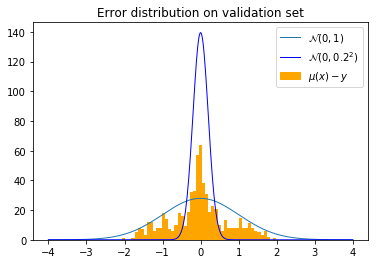

In [38]:
with open('./python_src/saved_models/oracle_mean_model.pkl', 'rb') as f:
    best_mean_model = pickle.load(f)
with open('./python_src/saved_models/oracle_var_model.pkl', 'rb') as f:
    best_var_model = pickle.load(f)
mean_model.load_state_dict(best_mean_model)
var_model.load_state_dict(best_var_model)
mean_model.eval()
var_model.eval()
val_batch = next(iter(dataloader_val))
X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
start_time = datetime.datetime.now()
Y_mean_pred = mean_model(X)
Y_var_pred = var_model(X)
end_time = datetime.datetime.now()
print((end_time - start_time))
e = (Y_mean_pred - Y).cpu().data.numpy().flatten()
ts = np.linspace(-4, 4, 400)
handle_normal, = plt.plot(ts, 70 * norm.pdf(ts), alpha=1.0, label='$\mathcal{N}(0, 1)$', linewidth=1.0)
handle_normal2, = plt.plot(ts, 70 * norm.pdf(ts, loc=0, scale=1 / 5.0), alpha=1.0, color='blue', label='$\mathcal{N}(0, 0.2^2)$', linewidth=1.0)
error_handle = mpatches.Patch(color='orange', label='$µ(x) - y$')
out = plt.hist(e, bins=np.linspace(-4, 4, 100), color='orange')
plt.title('Error distribution on validation set')
plt.legend(handles=[handle_normal, handle_normal2, error_handle])
#plt.savefig('error_distribution.pdf')
plt.show()

In [551]:
#with open('models/oracle_mean_model.pkl', 'wb') as f:
#    pickle.dump(best_mean_model, f)
#with open('models/oracle_var_model.pkl', 'wb') as f:
#    pickle.dump(best_var_model, f)

In [30]:
float_formatter = lambda x: "%.4f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

In [56]:
#val_batch = next(iter(dataloader_val))
#X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
X = Variable(
    torch.from_numpy(
        dataset_train.loc[28][
            ['x_0', 'x_1', 'x_2', 'x_3', 'y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2', 'y\'_3']
        ].values.astype(np.float32).reshape(1, -1)
    )
).cuda()
Y = Variable(
    torch.from_numpy(
        dataset_train.loc[28][
            ['u_0', 'u_1', 'u_2', 'u_3', 'u_4']
        ].values.astype(np.float32).reshape(1, -1)
    )
).cuda()
Y_mean_pred = mean_model(X).cpu().data.numpy()
Y_var_pred = var_model(X).cpu().data.numpy()
mean_pred = Y_mean_pred * training_σ.values[-5:] + training_μ.values[-5:]
std_pred = Y_var_pred * training_σ.values[-5:]
y_true = Y.cpu().data.numpy() * training_σ.values[-5:] + training_µ.values[-5:]
mean_pred[0], std_pred
y_true

array([[1.1121, -1.9445, 1.1616, 0.1598, 8.0001]])

In [43]:
dataset_.loc[28]

x_0      -0.394126
x_1       0.994688
x_2      -2.819700
y_0       0.135810
y_1      -0.311288
y_2      -2.936730
x'_0      0.863803
x'_1     -1.163890
x'_2     -1.512680
y'_0     -0.902363
y'_1     -3.149270
y'_2   -211.501000
u_0       1.112050
u_1      -1.944450
u_2       1.161550
u_3       0.159846
u_4       8.000090
Name: 28, dtype: float64

In [82]:
#with open('oracle-3-units-256-hidden-mean.pkl', 'wb') as f:
#    pickle.dump(mean_model.state_dict(), f)

# Pushability
$$p(x_t'|x_t)$$

## Datasets

In [113]:
dataset_ = pd.read_csv('./oracle_data.csv')

# Pick out data only where object pose changed
changed_inds = (dataset_['y_0'] != dataset_['y\'_0']) | (dataset_['y_1'] != dataset_['y\'_1']) | (dataset_['y_2'] != dataset_['y\'_2'])
dataset_ = dataset_[changed_inds]
dataset = dataset_.copy()

# Ignore robot successor state
dataset = dataset[[c for c in dataset.columns if 'x\'' not in c]]

# robot relative position
object_pos = dataset[[c for c in dataset.columns if 'y_' in c]]
for i in range(2):
    dataset.loc[:, 'x_{}'.format(i)] -= dataset['y_{}'.format(i)].values
# relative object change
for i in range(3):
    dataset.loc[:, 'y\'_{}'.format(i)] -= dataset['y_{}'.format(i)].values
# drop initial object x, y
dataset = dataset[[c for c in dataset.columns if c not in ['y_0', 'y_1']]]

# Remake angles θ to cos(θ), sin(θ). Redo as more automatically?
angles = dataset['x_2'].copy()
dataset['x_2'] = angles.apply('cos')
dataset['x_3'] = angles.apply('sin')
angles = dataset['y_2'].copy()
dataset['y_2'] = angles.apply('cos')
dataset['y_3'] = angles.apply('sin')
angles = dataset['y\'_2'].copy()
dataset['y\'_2'] = angles.apply('cos')
dataset['y\'_3'] = angles.apply('sin')

dataset = dataset[['y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2', 'y\'_3']]

# Decide where to split in training/validation/test
train_cut = int(len(dataset) * 0.9)
valid_cut = train_cut + int(len(dataset) * 0.05)
dataset_train_ = dataset[:train_cut]
dataset_val_ = dataset[train_cut:valid_cut]
dataset_test_ = dataset[valid_cut:]

# Normalize by training set statistics
training_µ = dataset_train_.mean()
training_σ = dataset_train_.std()
dataset_train = (dataset_train_ - training_µ) / training_σ
dataset_val = (dataset_train_ - training_µ) / training_σ
dataset_test = (dataset_train_ - training_µ) / training_σ

def get_dataloader(dataset, batch_size=32):
    X = dataset[[name for name in dataset.columns if name.startswith('y_')]]
    Y = dataset[[name for name in dataset.columns if name.startswith('y\'')]]
    return DataLoader(
        list(zip(X.as_matrix().astype(np.float32), Y.as_matrix().astype(np.float32))),
        batch_size=batch_size,
        shuffle=True
    )

dataloader_train = get_dataloader(dataset_train)
dataloader_val = get_dataloader(dataset_val, batch_size=128)
dataloader_test = get_dataloader(dataset_test, batch_size=128)

In [121]:
dataset_train[['y\'_0', 'y\'_1', 'y\'_2', 'y\'_3']].cov()
training_σ

y_2     0.708319
y_3     0.705899
y'_0    2.017727
y'_1    2.025916
y'_2    0.737853
y'_3    0.580616
dtype: float64

# Models:

In [108]:
X, Y = next(iter(dataloader_train))
x_size = X.size(1)
y_size = Y.size(1)
print('X and Y sizes:', x_size, y_size)
pushability_mean = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, y_size)
).cuda()

pushability_var = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, y_size),
    torch.nn.Softplus()
).cuda()

X and Y sizes: 2 4


In [109]:
mean_loss_fn = torch.nn.MSELoss()
mean_optim = torch.optim.Adam(pushability_mean.parameters(), weight_decay=1e-4)
var_loss_fn = gaussian_likelihood()
var_optim = torch.optim.Adam(pushability_var.parameters(), weight_decay=1e-4)

time_str = datetime.datetime.now().strftime('%H:%M')
logger_train = SummaryWriter('runs/resid-3-hidden-256-wd-1e-4-time-{}-pushability-train'.format(time_str))
logger_valid = SummaryWriter('runs/resid-3-hidden-256-wd-1e-4-time-{}-pushability-valid'.format(time_str))

In [110]:
best_val = np.inf
best_mean_model = None
best_var_model = None
step = 0
for _ in range(1024):
    for batch in dataloader_train:
        mean_model.train()
        pushability_var.train()
        X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), batch)
        Y_mean_pred = pushability_mean(X)
        Y_var_pred = pushability_var(X)

        pushability_mean.zero_grad()
        pushability_var.zero_grad()

        mse = mean_loss_fn(Y_mean_pred, Y)
        mse.backward(retain_graph=True)
        mean_optim.step()

        nll = var_loss_fn(Y_mean_pred, Y_var_pred, Y)
        nll.backward()
        var_optim.step()

        if step % 500 == 0:
            logger_train.add_scalar('mse', mse.cpu().data.numpy()[0], step)
            logger_train.add_scalar('nll', nll.cpu().data.numpy()[0], step)
            
            pushability_mean.eval()
            pushability_var.eval()
            val_batch = next(iter(dataloader_val))
            X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
            Y_mean_pred = pushability_mean(X)
            Y_var_pred = pushability_var(X)

            mse_val = mean_loss_fn(Y_mean_pred, Y)
            nll_val = var_loss_fn(Y_mean_pred, Y_var_pred, Y).cpu().data.numpy()[0]
            
            logger_valid.add_scalar('mse', mse_val.cpu().data.numpy()[0], step)
            logger_valid.add_scalar('nll', nll_val, step)
            
            if nll_val < best_val:
                best_val = nll_val
                best_mean_model = pushability_mean.state_dict()
                best_var_model = pushability_var.state_dict()

        step += 1

In [139]:
val_batch = next(iter(dataloader_val))
X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
Y_mean_pred = pushability_mean(X)
Y_var_pred = pushability_var(X)
Y_mean_pred[0, :], Y_var_pred[0, :]

(Variable containing:
 1.00000e-02 *
   0.8843
   0.8165
   2.6185
  -3.3960
 [torch.cuda.FloatTensor of size 4 (GPU 0)], Variable containing:
  0.9987
  1.0139
  0.9925
  0.9847
 [torch.cuda.FloatTensor of size 4 (GPU 0)])

## Conclusion
Super boring model, always predicts $\mathcal{N}(\mathbf{0, 1})$, which of course is absolutely correct.

# Feasibility
Predicts $p(x_{robot}|x_{target}, x_{target}')$

In [61]:
dataset_ = pd.read_csv('./oracle_data.csv')

# Pick out data only where object pose changed
changed_inds = (dataset_['y_0'] != dataset_['y\'_0']) | (dataset_['y_1'] != dataset_['y\'_1']) | (dataset_['y_2'] != dataset_['y\'_2'])
dataset_ = dataset_[changed_inds]
dataset = dataset_.copy()

# Ignore robot successor state
dataset = dataset[[c for c in dataset.columns if 'x\'' not in c]]

# robot relative position
object_pos = dataset[[c for c in dataset.columns if 'y_' in c]]
for i in range(2):
    dataset.loc[:, 'x_{}'.format(i)] -= dataset['y_{}'.format(i)].values
# relative object change
for i in range(3):
    dataset.loc[:, 'y\'_{}'.format(i)] -= dataset['y_{}'.format(i)].values
# drop initial object x, y
dataset = dataset[[c for c in dataset.columns if c not in ['y_0', 'y_1']]]

# Remake angles θ to cos(θ), sin(θ). Redo as more automatically?
angles = dataset['x_2'].copy()
dataset['x_2'] = angles.apply('cos')
dataset['x_3'] = angles.apply('sin')
angles = dataset['y_2'].copy()
dataset['y_2'] = angles.apply('cos')
dataset['y_3'] = angles.apply('sin')
angles = dataset['y\'_2'].copy()
dataset['y\'_2'] = angles.apply('cos')
dataset['y\'_3'] = angles.apply('sin')

dataset = dataset[['x_0', 'x_1', 'x_2', 'x_3', 'y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2', 'y\'_3']]

# Decide where to split in training/validation/test
train_cut = int(len(dataset) * 0.9)
valid_cut = train_cut + int(len(dataset) * 0.05)
dataset_train_ = dataset[:train_cut]
dataset_val_ = dataset[train_cut:valid_cut]
dataset_test_ = dataset[valid_cut:]

# Normalize by training set statistics
training_µ = dataset_train_.mean()
training_σ = dataset_train_.std()
dataset_train = (dataset_train_ - training_µ) / training_σ
dataset_val = (dataset_train_ - training_µ) / training_σ
dataset_test = (dataset_train_ - training_µ) / training_σ

def get_dataloader(dataset, batch_size=32):
    X = dataset[[name for name in dataset.columns if name.startswith('y')]]
    Y = dataset[[name for name in dataset.columns if name.startswith('x')]]
    return DataLoader(
        list(zip(X.as_matrix().astype(np.float32), Y.as_matrix().astype(np.float32))),
        batch_size=batch_size,
        shuffle=True
    )

dataloader_train = get_dataloader(dataset_train)
dataloader_val = get_dataloader(dataset_val, batch_size=128)
dataloader_test = get_dataloader(dataset_test, batch_size=128)

# Models:

In [62]:
hidden_size = 256
n_residual_units = 1

X, Y = next(iter(dataloader_train))
x_size = X.size(1)
y_size = Y.size(1)
print('X and Y sizes:', x_size, y_size)
feasability_mean = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    torch.nn.BatchNorm1d(hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, y_size),
).cuda()

feasability_var = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    torch.nn.BatchNorm1d(hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, y_size),
    torch.nn.Softplus()
).cuda()

X and Y sizes: 6 4


In [63]:
weight_decay = 1e-4
mean_loss_fn = torch.nn.MSELoss()
mean_optim = torch.optim.Adam(feasability_mean.parameters(), weight_decay=weight_decay)
var_loss_fn = gaussian_likelihood()
var_optim = torch.optim.Adam(feasability_var.parameters(), weight_decay=weight_decay)

time_str = datetime.datetime.now().strftime('%H:%M')
name = 'runs/fc-1-hidden-{}-wd-1e-4-time-{}-feasability'.format(
    hidden_size, time_str
)
logger_train = SummaryWriter(name + '-train'.format(n_residual_units, time_str))
logger_valid = SummaryWriter(name + '-valid'.format(n_residual_units, time_str))

In [64]:
best_val = np.inf
best_mean_model = None
best_var_model = None
step = 0
for _ in range(1024):
    for batch in dataloader_train:
        mean_model.train()
        feasability_var.train()
        X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), batch)
        Y_mean_pred = feasability_mean(X)
        Y_var_pred = feasability_var(X)

        feasability_mean.zero_grad()
        feasability_var.zero_grad()

        mse = mean_loss_fn(Y_mean_pred, Y)
        mse.backward(retain_graph=True)
        mean_optim.step()

        nll = var_loss_fn(Y_mean_pred, Y_var_pred, Y)
        nll.backward()
        var_optim.step()

        if step % 500 == 0:
            logger_train.add_scalar('mse', mse.cpu().data.numpy()[0], step)
            logger_train.add_scalar('nll', nll.cpu().data.numpy()[0], step)
            
            feasability_mean.eval()
            feasability_var.eval()
            val_batch = next(iter(dataloader_val))
            X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
            Y_mean_pred = feasability_mean(X)
            Y_var_pred = feasability_var(X)

            mse_val = mean_loss_fn(Y_mean_pred, Y)
            nll_val = var_loss_fn(Y_mean_pred, Y_var_pred, Y).cpu().data.numpy()[0]
            
            logger_valid.add_scalar('mse', mse_val.cpu().data.numpy()[0], step)
            logger_valid.add_scalar('nll', nll_val, step)
            
            if nll_val < best_val:
                best_val = nll_val
                best_mean_model = feasability_mean.state_dict()
                best_var_model = feasability_var.state_dict()

        step += 1

KeyboardInterrupt: 

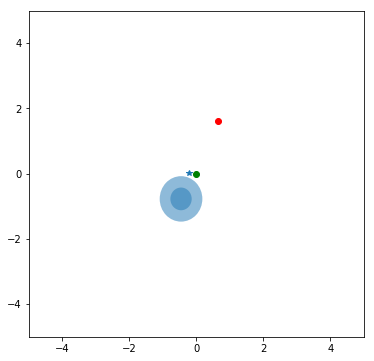

In [107]:
from matplotlib.patches import Ellipse

feasability_mean.load_state_dict(best_mean_model)
feasability_var.load_state_dict(best_var_model)

#with open('./python_src/saved_models/feasability_mean_model.pkl', 'wb') as f:
#    pickle.dump(best_mean_model, f)
#with open('./python_src/saved_models/feasability_var_model.pkl', 'wb') as f:
#    pickle.dump(best_var_model, f)

fig, ax = plt.subplots(figsize=(6, 6))
val_batch = next(iter(dataloader_val))
X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
Y_mean_pred = feasability_mean(X).cpu().data.numpy()
Y_var_pred = feasability_var(X).cpu().data.numpy()
X = X.cpu().data.numpy()
Y = Y.cpu().data.numpy()
Y_mean_pred[0, :], Y[0, :], Y_var_pred[0, :]
std1 = Ellipse(Y_mean_pred[0, :2], width=Y_var_pred[0, 0] ** 0.5, height=Y_var_pred[0, 1] ** 0.5, alpha=0.5)
ax.add_artist(std1)
std2 = Ellipse(Y_mean_pred[0, :2], width=2 * Y_var_pred[0, 0] ** 0.5, height=2 * Y_var_pred[0, 1] ** 0.5, alpha=0.5)
ax.add_artist(std2)
plt.plot(0.0, 0.0, 'go')
plt.plot(X[0, 2], X[0, 3], 'ro')
plt.plot(Y[0, 0], Y[0, 1], '*')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

In [112]:
training_µ

x_0     0.006034
x_1    -0.008209
x_2    -0.001866
x_3     0.001664
y_2     0.003809
y_3     0.003643
y'_0   -0.002864
y'_1    0.017553
y'_2    0.344222
y'_3   -0.001551
dtype: float64